<a href="https://colab.research.google.com/github/john-tseng-710/DL/blob/master/TL_VGG16_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import glob
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Trnasfer Learning：ensemble pretrained VGG16 with self-defined MLP 

In [2]:
# VGG16:
#   input_shape: conventionally use (224, 224, 3) as VGG16 model is trained using photos of this dimension
#   include_top: True: use original 10-class-MLP, False: use self-defined MLP
#   weights: defaultly use 'imagenet' pretrained weights
vgg = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    )
vgg.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

# Data Preprocessing

In [4]:
# Do NOT read image until training starts
df = pd.DataFrame(columns=['path', 'label'])
for p in glob.glob('./drive/My Drive/dogs_vs_cats/train/cat.*.jpg'):
  s = pd.Series([p, 0], index=['path', 'label'])
  df = df.append(s, ignore_index=True)
for p in glob.glob('./drive/My Drive/dogs_vs_cats/train/dog.*.jpg'):
  s = pd.Series([p, 1], index=['path', 'label'])
  df = df.append(s, ignore_index=True)
df

,path,label
0,./drive/My Drive/dogs_vs_cats/train/cat.9551.jpg,0
1,./drive/My Drive/dogs_vs_cats/train/cat.9565.jpg,0
2,./drive/My Drive/dogs_vs_cats/train/cat.9547.jpg,0
3,./drive/My Drive/dogs_vs_cats/train/cat.9585.jpg,0
4,./drive/My Drive/dogs_vs_cats/train/cat.9575.jpg,0
...,...,...
24995,./drive/My Drive/dogs_vs_cats/train/dog.1012.jpg,1
24996,./drive/My Drive/dogs_vs_cats/train/dog.10119.jpg,1
24997,./drive/My Drive/dogs_vs_cats/train/dog.10142.jpg,1
24998,./drive/My Drive/dogs_vs_cats/train/dog.1014.jpg,1


(224, 224)
1


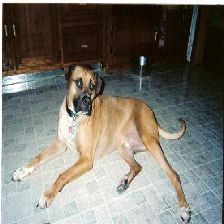

In [5]:
# Preview & Unify image size w/ keras.preprocessing.image.load_img('path', target_size=(?, ?)) 
random_idx = np.random.randint(0, 25000)
random_img = load_img(df['path'][random_idx], target_size=(224, 224))
print(random_img.size)
print(f"{df['label'][random_idx]}")
random_img

# Build Model
** Add Batch Normalization between CNN and MLP to avoid dead Relu in MLP**
>Batch Normalization basically adjusts input data distribution to an acceptable range for MLP by moving average and scaling standard deviation

In [6]:
# VGG was built w/ keras.models.Model
# check VGG input/output
print(vgg.input)
print(vgg.output)

Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)
Tensor("block5_pool/MaxPool:0", shape=(None, 7, 7, 512), dtype=float32)


In [36]:
# Fix CNN parameters to save training time
for l in vgg.layers:
  l.trainable = False
bn = BatchNormalization()(vgg.output) # Add Batch Normalization between CNN and MLP to avoid dead Relu in MLP
mlp = Flatten()(bn)   # Flatten returns a function
mlp = Dense(units=2048, activation='relu')(mlp)  # Dense does the same, units set 1/10 flatened input size 0.1*(7*7*512)
mlp = Dense(units=256, activation='relu')(mlp)
# For binary classification units can either be 1 with activation='sigmoid' or 2 with actiovation='softmax'
mlp = Dense(units=2, activation='softmax')(mlp)

model = Model(inputs=vgg.input, outputs=mlp)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

# Compile Model

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
1. For saving memory, split train/validation data using scikit-learn for large data
2. Convert dataframe columns(Series) to np.array before splitting first

In [38]:
# Label one-hot-encoding
label_cat = to_categorical(df['label'])

train_data, valid_data, train_label, valid_label = train_test_split(df['path'].to_numpy(), label_cat, test_size=0.1)
print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)

(22500,)
(22500, 2)
(2500,)
(2500, 2)


## Note!: While Transfer Learining, MUST use exactly the same data preprocessing before training
## E.g VGG converts RGB to BGR and subtract channel average value for each single channel

In [43]:
epochs = 5
batch_size = 20
for epoch in range(epochs):
  idx = np.random.randint(0, train_data.shape[0], batch_size)
  imgs = []
  for p in train_data[idx]:
    # Load image and preprocees image w/ VGG original preprocess method
    img = load_img(p, target_size=(224, 224))
    img = preprocess_input(np.array(img))
    imgs.append(img)
  train_data_batch = np.array(imgs)
  train_label_batch = train_label[idx]
  # train on batch
  result = model.train_on_batch(train_data_batch, train_label_batch)
  print(f'----- Epoch:{epoch} -----')
  print(result)

----- Epoch:0 -----
[3.905252695083618, 0.9333333373069763]
----- Epoch:1 -----
[1.6993916034698486, 0.8999999761581421]
----- Epoch:2 -----
[0.21152786910533905, 0.949999988079071]
----- Epoch:3 -----
[0.11005227267742157, 0.949999988079071]
----- Epoch:4 -----
[0.8790229558944702, 0.8999999761581421]


# Evaluate & Predict

In [55]:
batch_size = 100
idx = np.random.randint(0, valid_data.shape[0], batch_size)
ori_imgs = []
imgs = []
for p in valid_data[idx]:
  # Load image and preprocees image w/ VGG original preprocess method
  img = load_img(p, target_size=(224, 224))
  ori_imgs.append(img)
  img = preprocess_input(np.array(img))
  imgs.append(img)
valid_data_batch = np.array(imgs)
valid_label_batch = valid_label[idx]
evaluate = model.evaluate(valid_data_batch, valid_label_batch)
print(evaluate)
predict = model.predict(valid_data_batch)
print(predict)

4/4 [==============================] - 0s 72ms/step - loss: 3.0126 - accuracy: 0.9100
[3.012565851211548, 0.9100000262260437]
[[1.00000000e+00 2.70425377e-10]
 [1.00000000e+00 2.42056857e-23]
 [1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 2.25583700e-25]
 [9.99997973e-01 1.97464578e-06]
 [2.31317437e-27 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 7.09418414e-28]
 [1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [9.49052529e-22 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 5.08228979e-32]
 [8.95474195e-01 1.04525775e-01]
 [5.44148035e-20 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 9.79775499e-24]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 6.19267249e-10]
 [1.00000000e+00 0.00000000e+00]
 [9.99966979e-01 3.30358416e-05]
 [1.00000000e+00 1.06974793e-26]
 [1.00000000e+00 4.85445391e-08]
 [0.00000000e+00

# Visualize Result

[32 36 39 41 48 65 66 88 94]


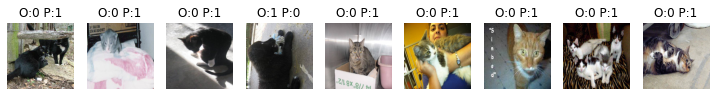

In [63]:
unmatch_idx = np.nonzero(predict.argmax(axis=-1) != valid_label_batch.argmax(axis=-1))[0]
print(unmatch_idx)

col = 10
row = (batch_size/10)+1 if batch_size%10 else batch_size
plt.figure(figsize=(14, 450))

for i, idx in enumerate(unmatch_idx):
  unmatch_img = ori_imgs[idx]
  unmatch_ori_label = valid_label_batch.argmax(axis=-1)[idx]
  unmatch_p_label = predict.argmax(axis=-1)[idx]
  plt.subplot(row, col, i+1)
  plt.title(f'O:{unmatch_ori_label} P:{unmatch_p_label}')
  plt.axis('off')
  plt.imshow(unmatch_img)
plt.show()